In [41]:
%matplotlib inline
import datetime
import requests
from lxml import html
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
url = 'http://asuntojen.hintatiedot.fi/haku/' # the URL for query
headers = {'content-type':'application/x-www-form-urlencoded'} # set the content type to form 
data = 'search=1&l=0&c=&cr=1&ps=00100&pc=0&nc=0&h=1&r=1&amin=&amax=' # query string, check form HTML for meanings

In [5]:
response = requests.post(url,data=data,headers=headers)
tree = html.fromstring(response.content)

You can use Chrome developer tools to find out the right DOM element and right click + copy XPath to get the right expression to clipboard.

In [6]:
apartments_list = tree.xpath('//*[@id="mainTable"]/tbody[3]/tr') 
# remove the first because of the crappy HTML
apartments_list.pop(0)

<Element tr at 0x7ff4c4a49b50>

In [7]:
# convert to array
apartments = []
for apartment in apartments_list:
    apartment = [f.text_content() for f in apartment]
    apartments.append(apartment)

In [42]:
cols = ['area',
       'desc',
       'type',
       'size',
       'price',
       'psqm',
       'year',
       'floor',
       'elevator',
       'condition',
       'energy']
p = pd.DataFrame(apartments,columns=cols)
# let's do some wrangling
p=p.drop('psqm',1) # drop redundant column
p['rooms'] = 1 # add explicit room number information from the search
p['areacode'] = 100 
p['size'] = p['size'].str.replace(",", ".").astype(float)
p['price'] = p['price'].astype(float)
p = p[p.desc != 'AH'] # Kludge do this properly
# handle floors
p['floors'] = p['floor'].str.split('/',expand=True)[1].astype(int)
p['floor'] = p['floor'].str.split('/',expand=True)[0].astype(int)
condition_le = LabelEncoder()
elevator_le = LabelEncoder()

p.condition = condition_le.fit_transform(p.condition)
p.elevator = condition_le.fit_transform(p.elevator)

p['date'] = datetime.datetime.now().date()

p

,area,desc,type,size,price,year,floor,elevator,condition,energy,rooms,areacode,floors,date
0,Kamppi,"1 h, kk, kh",kt,22.0,182000.0,1963,4,1,2,F2007,1,100,5,2016-10-04
1,Kamppi,"1h, kt, sauna, ...",kt,35.0,296000.0,1910,5,0,1,,1,100,5,2016-10-04
2,Kamppi,"1h, avok",kt,33.0,299500.0,1910,6,0,1,,1,100,6,2016-10-04
3,Etu-Töölö,"1h, avok, kph, ...",kt,40.0,220000.0,1927,5,1,2,F2007,1,100,6,2016-10-04
4,Etu-Töölö,"1h, avok, kph, ...",kt,40.0,220000.0,1927,5,1,2,F2007,1,100,6,2016-10-04
7,Kamppi,"1h, avokeitti...",kt,44.5,362000.0,1910,5,0,1,,1,100,5,2016-10-04
8,Etu-Töölö,"1 h, avokeitti&...",kt,24.0,190000.0,1929,6,1,1,C,1,100,7,2016-10-04
10,Etu-Töölö,"1 h, avokeitti&...",kt,27.0,206000.0,1934,4,1,1,F,1,100,4,2016-10-04
12,Etu-Töölö,"1h, k",kt,39.5,267500.0,1922,3,1,1,,1,100,6,2016-10-04
13,Kamppi,1 h+kk,kt,30.0,220000.0,1927,3,1,2,F,1,100,6,2016-10-04


In [43]:
# drop text fields 
p = p[['size','price','year','elevator','condition','floor','floors']]
p

,size,price,year,elevator,condition,floor,floors
0,22.0,182000.0,1963,1,2,4,5
1,35.0,296000.0,1910,0,1,5,5
2,33.0,299500.0,1910,0,1,6,6
3,40.0,220000.0,1927,1,2,5,6
4,40.0,220000.0,1927,1,2,5,6
7,44.5,362000.0,1910,0,1,5,5
8,24.0,190000.0,1929,1,1,6,7
10,27.0,206000.0,1934,1,1,4,4
12,39.5,267500.0,1922,1,1,3,6
13,30.0,220000.0,1927,1,2,3,6


array([[<matplotlib.axes.AxesSubplot object at 0x7ff4c3224650>,
        <matplotlib.axes.AxesSubplot object at 0x7ff4c29895d0>]], dtype=object)

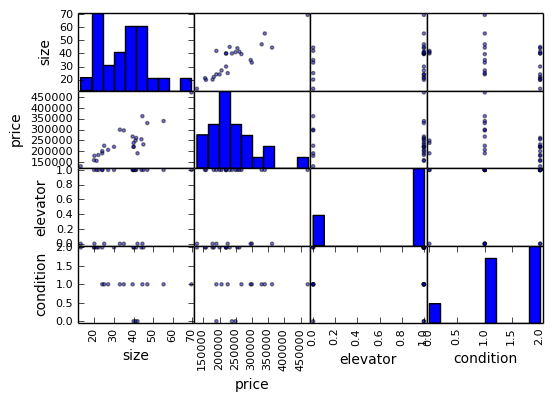

In [44]:
scattercols = ['size','price','elevator','condition']
pd.scatter_matrix(p[scattercols])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(p.drop(['price'], axis=1),
                                                    p.price, test_size=0.2, random_state=20)


In [46]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

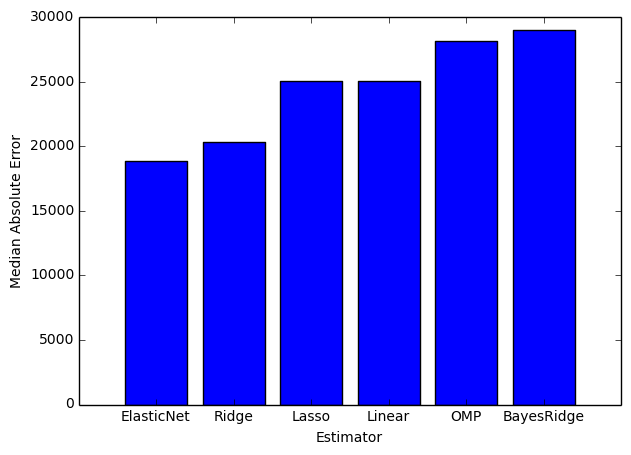

In [47]:
for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [48]:
n_est = 300

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_

In [49]:
best

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='lad', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=1, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

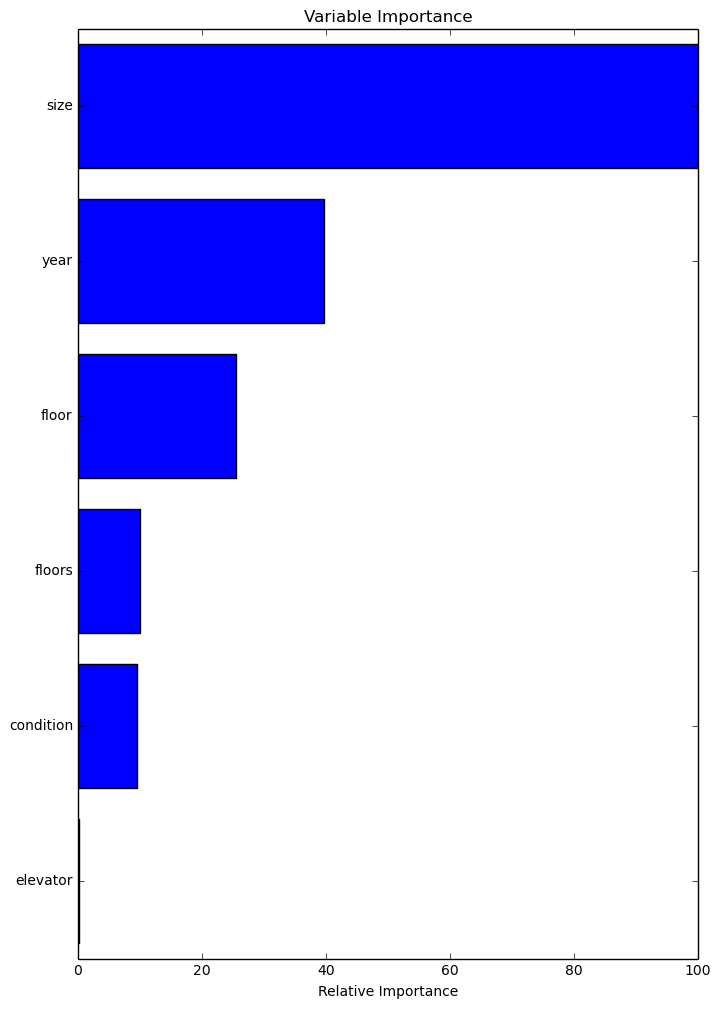

In [50]:

feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

In [52]:
feature = np.array([30.0,1960,0,1,2,3])
best.predict(feature.reshape(1,-1))

array([ 224909.35740143])

In [22]:
best.__class__

sklearn.ensemble.gradient_boosting.GradientBoostingRegressor

In [23]:
# model persistence works through pickle
import pickle
pickle.dumps(best)

'ccopy_reg\n_reconstructor\np0\n(csklearn.ensemble.gradient_boosting\nGradientBoostingRegressor\np1\nc__builtin__\nobject\np2\nNtp3\nRp4\n(dp5\nS\'verbose\'\np6\nI0\nsS\'min_samples_leaf\'\np7\nI1\nsS\'max_features\'\np8\nNsS\'n_classes_\'\np9\nI1\nsS\'init\'\np10\nNsS\'random_state\'\np11\nNsS\'criterion\'\np12\nS\'friedman_mse\'\np13\nsS\'min_weight_fraction_leaf\'\np14\nF0.0\nsS\'min_samples_split\'\np15\nI1\nsS\'_sklearn_version\'\np16\nS\'0.18\'\np17\nsS\'max_depth\'\np18\nI4\nsS\'loss_\'\np19\ng0\n(csklearn.ensemble.gradient_boosting\nLeastAbsoluteError\np20\ng2\nNtp21\nRp22\n(dp23\nS\'K\'\np24\nI1\nsbsS\'warm_start\'\np25\nI00\nsS\'estimators_\'\np26\ncnumpy.core.multiarray\n_reconstruct\np27\n(cnumpy\nndarray\np28\n(I0\ntp29\nS\'b\'\np30\ntp31\nRp32\n(I1\n(I300\nI1\ntp33\ncnumpy\ndtype\np34\n(S\'O8\'\np35\nI0\nI1\ntp36\nRp37\n(I3\nS\'|\'\np38\nNNNI-1\nI-1\nI63\ntp39\nbI00\n(lp40\ng0\n(csklearn.tree.tree\nDecisionTreeRegressor\np41\ng2\nNtp42\nRp43\n(dp44\nS\'presort\'\np45\nS\'

In [54]:
p.iloc[0].to_json() # how to convert one record to JSON

'{"size":22.0,"price":182000.0,"year":"1963","elevator":1,"condition":2,"floor":4,"floors":5}'

In [57]:
p.to_json(orient='records') # persist to db from here

'[{"size":22.0,"price":182000.0,"year":"1963","elevator":1,"condition":2,"floor":4,"floors":5},{"size":35.0,"price":296000.0,"year":"1910","elevator":0,"condition":1,"floor":5,"floors":5},{"size":33.0,"price":299500.0,"year":"1910","elevator":0,"condition":1,"floor":6,"floors":6},{"size":40.0,"price":220000.0,"year":"1927","elevator":1,"condition":2,"floor":5,"floors":6},{"size":40.0,"price":220000.0,"year":"1927","elevator":1,"condition":2,"floor":5,"floors":6},{"size":44.5,"price":362000.0,"year":"1910","elevator":0,"condition":1,"floor":5,"floors":5},{"size":24.0,"price":190000.0,"year":"1929","elevator":1,"condition":1,"floor":6,"floors":7},{"size":27.0,"price":206000.0,"year":"1934","elevator":1,"condition":1,"floor":4,"floors":4},{"size":39.5,"price":267500.0,"year":"1922","elevator":1,"condition":1,"floor":3,"floors":6},{"size":30.0,"price":220000.0,"year":"1927","elevator":1,"condition":2,"floor":3,"floors":6},{"size":25.0,"price":225000.0,"year":"1934","elevator":0,"condition"